In [1]:
from si import *

Not a jupyter notebook. Not enabling notebook functions.
Welcome to JupyROOT 6.20/04
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


# Slow term search using KS statistic on energy spectrum

### Goal: look at the energy spectrum very late in the fill, compare with rolling omega_a period, see if we can see anything strange

---


In [2]:
# f = r.TFile("./data/run2c_pileup_corrected_non.root")
# f = r.TFile("./data/results_clustersAndCoinc_randomized_July7.root")
f = r.TFile("./data/results_clustersAndCoinc_randomized_July7_pileup_corrected.root")
f.cd("clustersAndCoincidences")
f.ls()

TFile**		./data/results_clustersAndCoinc_randomized_July7_pileup_corrected.root	
 TFile*		./data/results_clustersAndCoinc_randomized_July7_pileup_corrected.root	
  TDirectoryFile*		clustersAndCoincidences	clustersAndCoincidences
   KEY: TH3D	uncorrected;1	uncorrected
   KEY: TH3D	corrected;1	corrected
   KEY: TH2I	triples;1	triples
   KEY: TH2I	quadruples;1	quadruples
   KEY: TH1I	ctag;1	ctag
  KEY: TDirectoryFile	clustersAndCoincidences;1	clustersAndCoincidences


In [3]:
h = f.Get("clustersAndCoincidences/corrected").Clone()

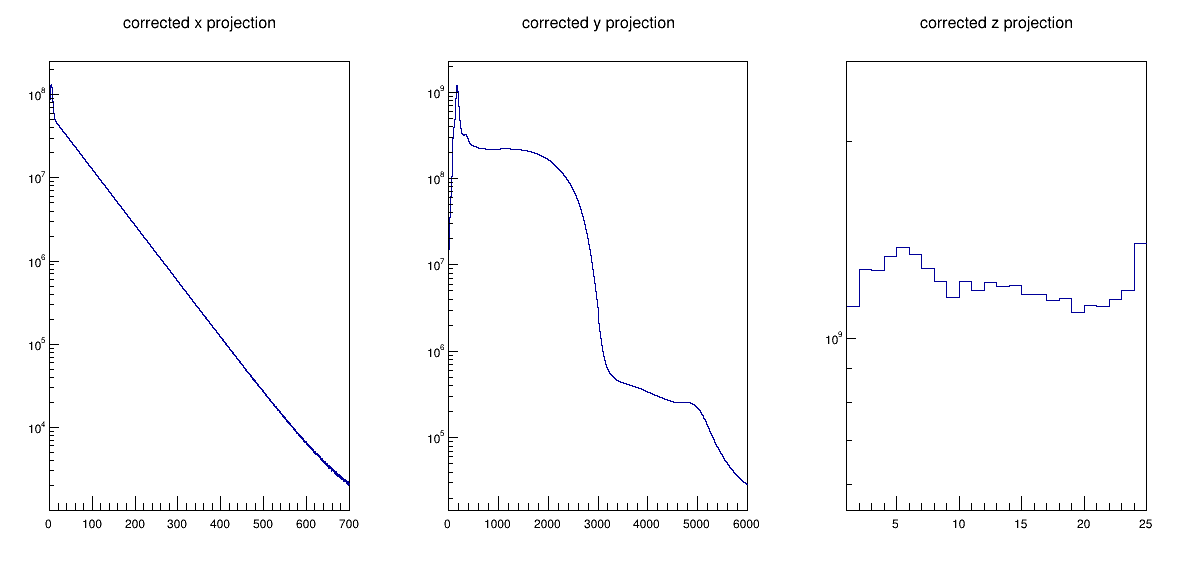

In [4]:
c = r.TCanvas("c","c",1200,600)
c.Divide(3)
for i,xi in enumerate(['x','y','z']):
    c.cd(i+1)
    h.Project3D(xi).Draw()
    r.gPad.SetLogy()
c.Draw()

In [5]:
omega_a_period = 4.37 # microseconds

In [6]:
width = h.GetXaxis().GetBinWidth(10)
print(width)
print(omega_a_period/width)
print(width*29)

0.14919011082693948
29.291485714285713
4.3265132139812446


### We only care about things which make it into our omega_a fits, so we can ignore everything below a certain energy

In [7]:
eLow = 2000
eHigh = 3100

tlow = 25
thigh = 400

In [8]:
h.GetYaxis().SetRangeUser(eLow,eHigh)

### Lets get our reference spectrum

In [9]:
nperiods = 50
thigh1 = 400
thigh2 = thigh1 + nperiods * omega_a_period
print(thigh1, thigh2)
# thigh2 = 700 #change to N exact g-2 periods

h.GetXaxis().SetRangeUser(thigh1, thigh2)

ref_spectrum = h.Project3D("y").Clone("ref_spectrum")
ref_spectrum.Scale(1/ref_spectrum.Integral())

400 618.5


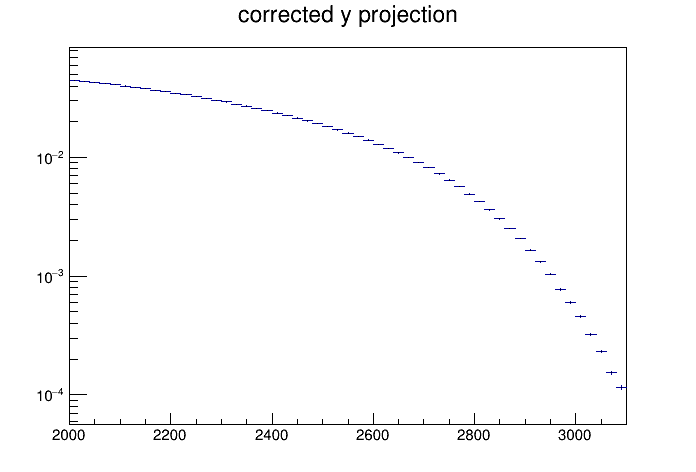

In [10]:
c = r.TCanvas()
ref_spectrum.Draw()
c.SetLogy()
c.Draw()

---

### Use root chi^2 test to compare the two histograms
https://root.cern.ch/doc/master/classTH1.html#a6c281eebc0c0a848e7a0d620425090a5

In [11]:
%%time

hists = []
times = []
ks = []
for bini in range(h.GetNbinsX()):
    bincenter = h.GetXaxis().GetBinCenter(bini)
    if(bincenter < tlow or bincenter > thigh):
        continue
    if(bini % 1000 == 0):
        print(bini)
    t1 = bincenter - omega_a_period/2
    t2 = bincenter + omega_a_period/2
    h.GetXaxis().SetRangeUser(t1,t2)
    hi = h.Project3D("y").Clone("h_"+str(bini))
    hi.Scale(1/hi.Integral())
    hists.append(hi.Clone())
    times.append(bincenter)
    ks.append( ref_spectrum.Chi2Test(hi,"UU NORM CHI2/NDF") )
    

1000
2000
CPU times: user 1.07 s, sys: 28.3 ms, total: 1.1 s
Wall time: 1.09 s


In [12]:
print(times[:10])
print(ks[:10])

[25.1385336743393, 25.28772378516624, 25.43691389599318, 25.58610400682012, 25.735294117647058, 25.884484228473998, 26.033674339300937, 26.182864450127877, 26.332054560954816, 26.481244671781756]
[1.562261574780574, 1.5684922504318555, 1.5982947383879664, 1.5960169587542437, 1.6058766402299849, 1.5814960790631059, 1.6055251657564849, 1.6450181631795375, 1.6538042954694918, 1.7033971571514273]


In [13]:
getBlinded = Blinders(FitType.Omega_a, 'Second verse, same as the first')

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [31]:
def randomized_fit(x,p):
    time = x[0]    
    c = p[0]
    m = p[1]
    
    tau = p[2]
    A = p[3]
    omega = p[4]
    phi = p[5] 
    
    return c + m*time + math.exp(-1.0*time/tau)*A#*math.cos(omega*time + phi)

func = r.TF1("func", randomized_fit, 40,350,6)
func.SetParameters(1,0,30,-5,.05,0)
func.SetParNames("C","m","#tau","A","#omega","#phi")

In [32]:
fit = fitVector(times, ks, func, nFit=2)

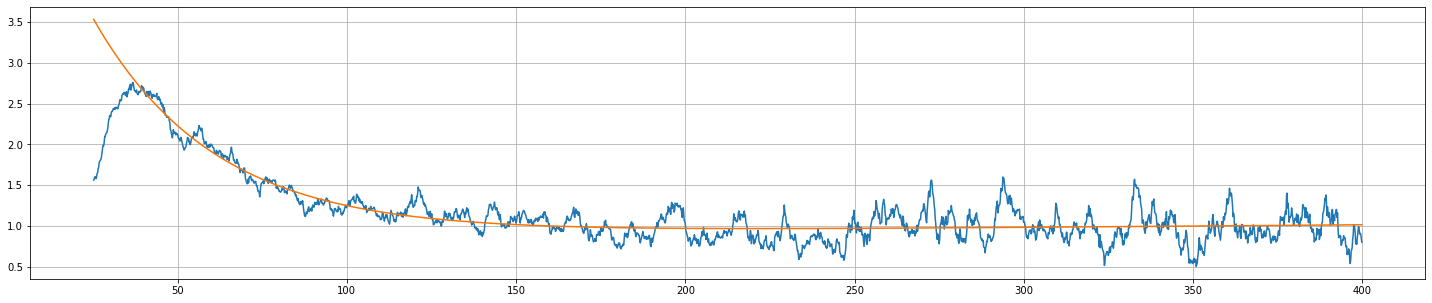

In [33]:
fig,ax = plt.subplots(figsize=(25,5))
# fit.f.SetParameters(1,-0.0003,15,-0.005,0.0008,math.pi/2.)
fit.drawFitResult(ax, 10000)
plt.plot(times,ks,"-")
plt.grid()
plt.show()

In [34]:
print(fit.pars)

[0.8842107833647439, 0.00032422336143093586, 36.101225635836286, 5.303940642662946, -218944.4942115227, 0.0]


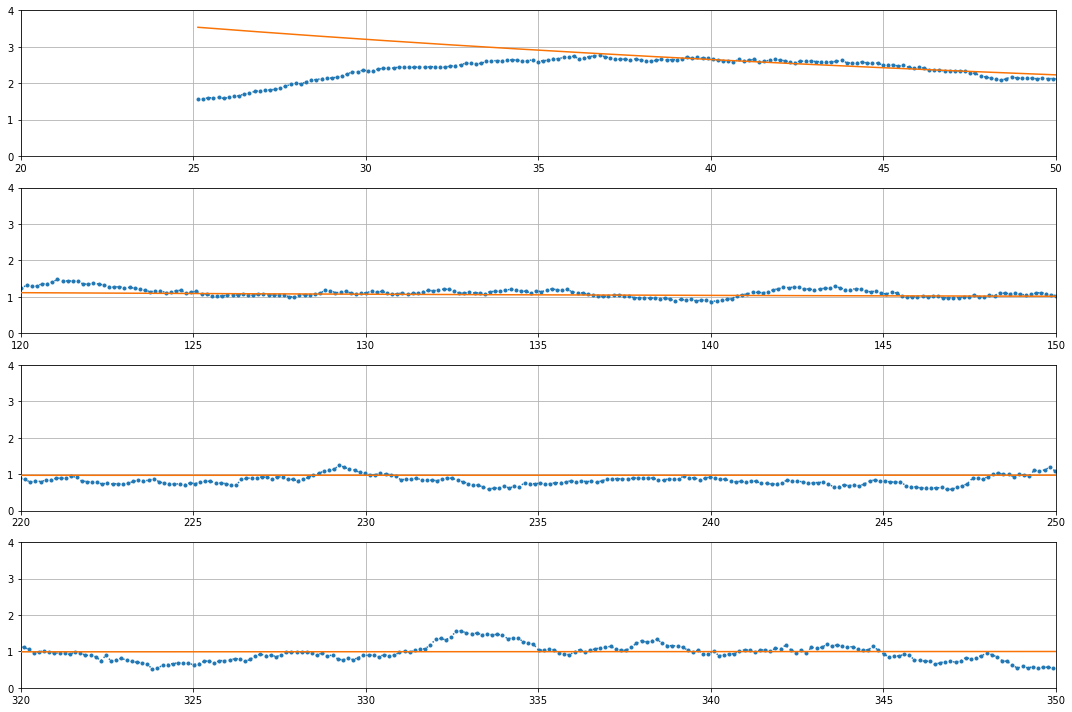

In [35]:
fig,ax = plt.subplots(4,1,figsize=(15,10))
for i,axi in enumerate(ax):
    axi.plot(times,ks,".:")
    axi.set_xlim(20+(100*i),50+(100*i))
    fit.drawFitResult(axi, 10000)
    axi.grid()
    axi.set_ylim(0,4)
# plt.yscale("log")
plt.tight_layout()
plt.show()

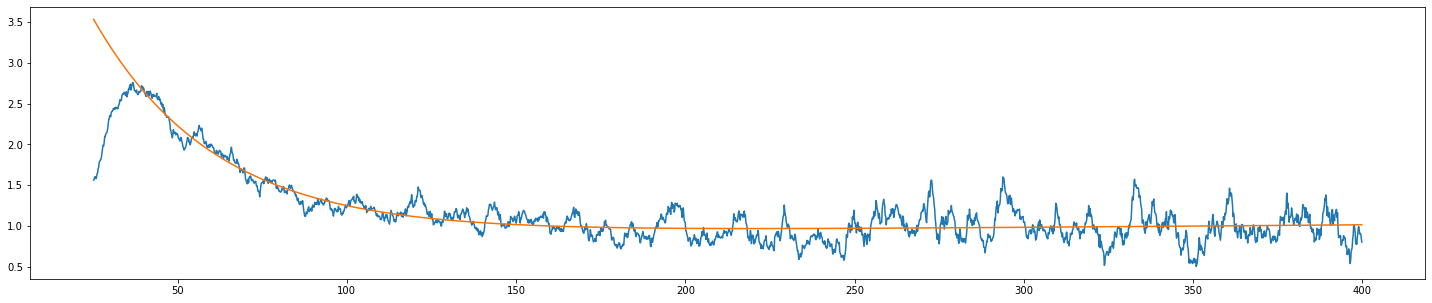

In [36]:
fig,ax = plt.subplots(figsize=(25,5))
fit.drawFitResult(ax, 10000)
plt.plot(times,ks,"-")
plt.show()

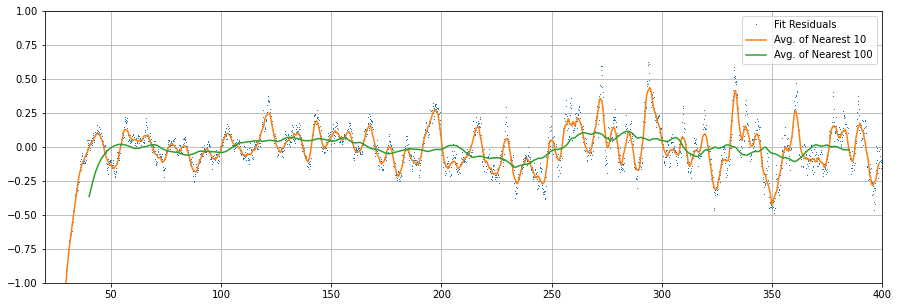

In [37]:
fig,ax = plt.subplots(figsize=(15,5))
fit.plotResiduals(ax, 2,",",runningAverage=1)
fit.plotResiduals(ax, 2,"-",runningAverage=10,labeli="Avg. of Nearest 10")
fit.plotResiduals(ax, 2,"-",runningAverage=100,labeli="Avg. of Nearest 100")
plt.xlim(20,400)
plt.ylim(-1,1)
plt.grid()
plt.legend(loc=1)
plt.show()

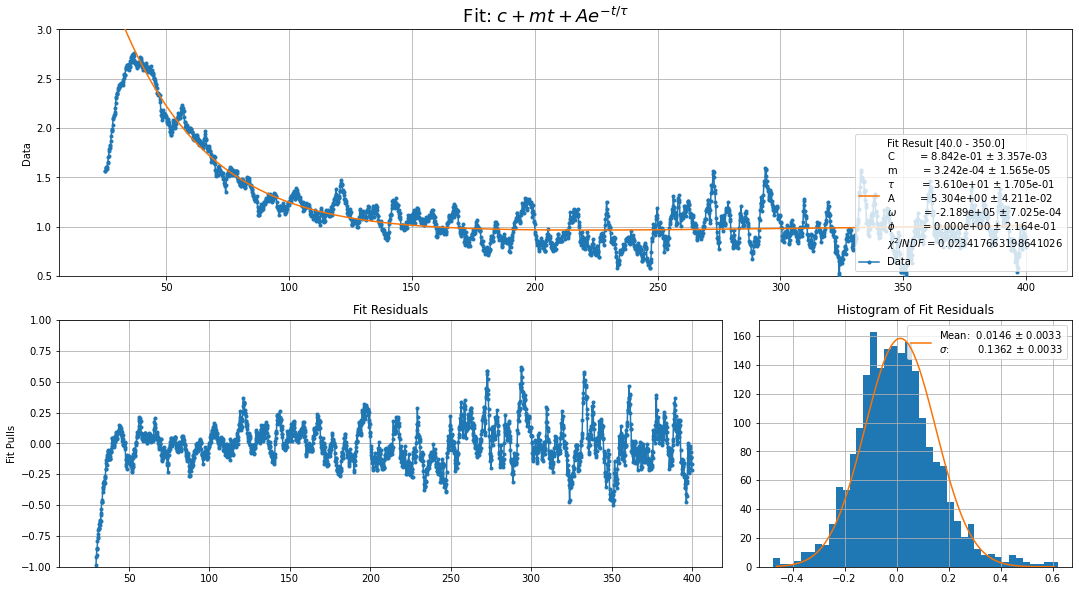

In [40]:
fig, ax = fit.draw(draw_confidence_intervals=False)
# plt.suptitle(r" Fit: $c + mt + e^{-t/\tau}*A cos(\omega t + \phi)$", y=1.02, fontsize=18)
plt.suptitle(r" Fit: $c + mt + Ae^{-t/\tau} $", y=1.02, fontsize=18)
ax[1].set_ylim(-1,1)
ax[0].set_ylim(0.5,3)
plt.show()

Restricting range of FFT to: [20, 300]


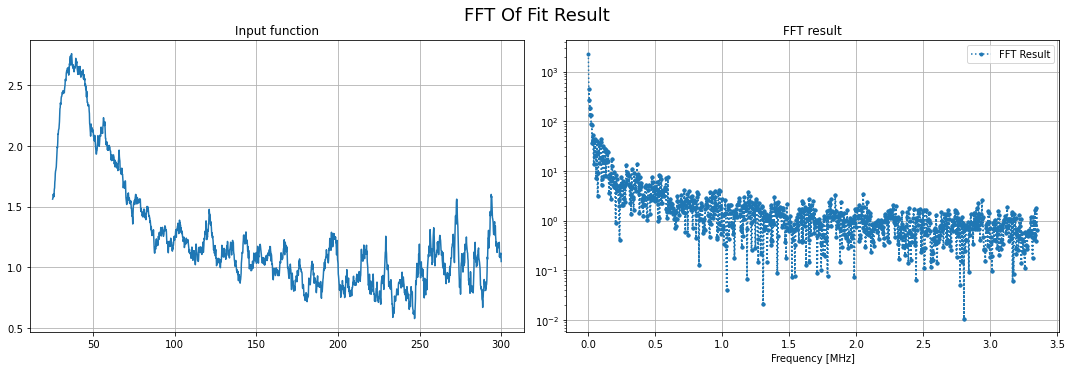

In [23]:
ding = fit.fft([20,300],0)

Restricting range of FFT to: [20, 300]


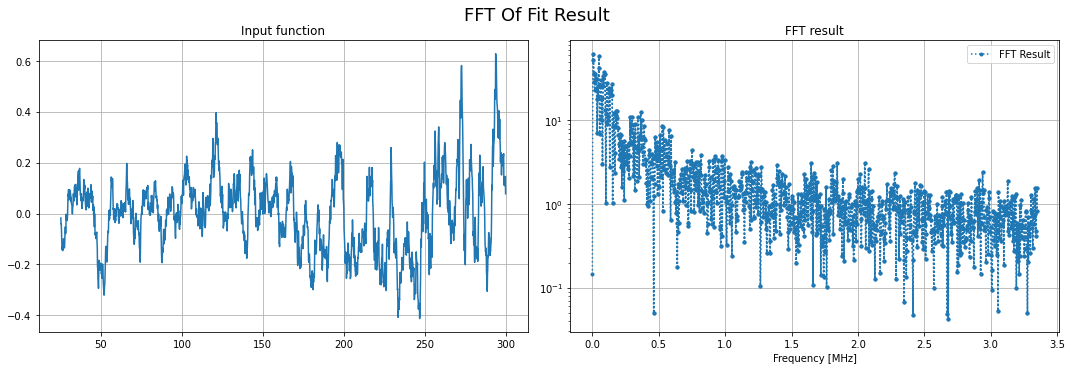

In [24]:
ding = fit.fft([20,300],1)

In [25]:
len(ding[0])/2

921.5

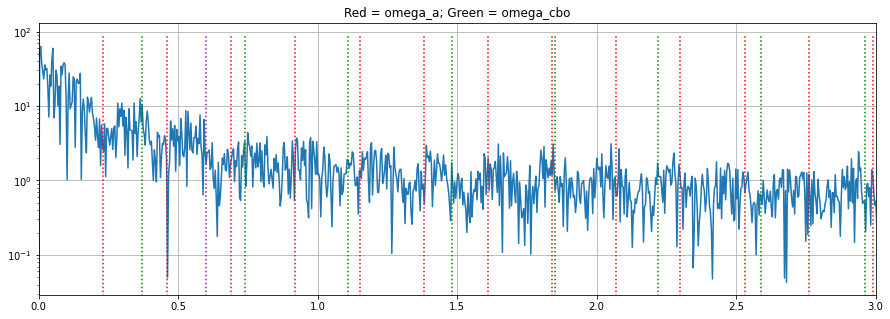

In [26]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(ding[0][:int(len(ding[0])/2)], np.abs(ding[1][:int(len(ding[0])/2)]))
plt.xlim(0,3)
omega_a = 0.23
for i in range(15):
    plt.plot([i*omega_a, i*omega_a], [0,1.41*max(np.abs(ding[1][:int(len(ding[0])/2)]) )], "r:")
omega_cbo = 0.37
for i in range(15):
    plt.plot([i*omega_cbo, i*omega_cbo], [0,1.41*max(np.abs(ding[1][:int(len(ding[0])/2)]) )], "g:")
plt.plot([omega_cbo+omega_a,omega_cbo+omega_a], [0,1.41*max(np.abs(ding[1][:int(len(ding[0])/2)]) )], ":", color="xkcd:purple")
plt.grid()
plt.yscale("log")
plt.title("Red = omega_a; Green = omega_cbo")
plt.show()